In [1]:
from rdkit import Chem
from rdkit.Chem.rdMolTransforms import ComputeCentroid
from rdkit.Chem.AllChem import ComputeMolVolume
import numpy as np
from rdkit.Chem import PandasTools
from sklearn.metrics import pairwise_distances
from tqdm.auto import tqdm
import pandas as pd
import py3Dmol
import seaborn as sns

In [2]:
tqdm.pandas()

Define a couple of utility functions

In [3]:
def read_sdf(infile_name):
    suppl = Chem.SDMolSupplier(infile_name)
    for mol in suppl:
        break
    return mol

def get_center(mol):
    return np.array(ComputeCentroid(mol.GetConformer(0)))

Define a function to show 3D structures with py3Dmol

In [4]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

Read the SD file with the fragments into a Pandas dataframe

In [5]:
df = PandasTools.LoadSDF("ligs.sdf")
df.shape

(204, 3)

Add the center and volume for each fragment to the dataframe

In [6]:
df['center'] = df.ROMol.progress_apply(get_center)
df['volume'] = df.ROMol.progress_apply(ComputeMolVolume)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Create a matrix of distances between molecule centers

In [7]:
center_list = np.stack(df.center.values)
dist_mat = pairwise_distances(center_list,center_list)
dist_mat.shape

(204, 204)

Loop over dist_mat and collect all pairs of fragments where the distance is less than dist_cutoff.  Calcualte volume of the fragment pair and the ratio of the volume of the fragment pair to the sum of the volumes of the individual fragments. 

In [8]:
dist_cutoff = 20
res = []
for i,j in tqdm(np.argwhere(dist_mat < dist_cutoff)):
    if i < j: 
        mol_i = df.ROMol.values[i]
        mol_j = df.ROMol.values[j]
        vol_i = df.volume.values[i]
        vol_j = df.volume.values[j]
        name_i = df.Name.values[i]
        name_j = df.Name.values[j]
        combo_mol = Chem.CombineMols(mol_i,mol_j)
        combo_vol = ComputeMolVolume(combo_mol)        
        sum_vol = vol_i + vol_j
        res.append([combo_mol,i,j,name_i,name_j,dist_mat[i,j],vol_i, vol_j, combo_vol, combo_vol/sum_vol])  

  0%|          | 0/13444 [00:00<?, ?it/s]

Plug the results of the previous cell into a dataframe. 

In [9]:
cols = ["ROMol","i","j","name_i","name_j","dist","vol_i","vol_j","combo_vol","vol_ratio"]
vol_df = pd.DataFrame(res,columns=cols)

In [10]:
sns.set_context('talk')

Text(0.5, 21.44444444444443, 'Distance Between Centers')

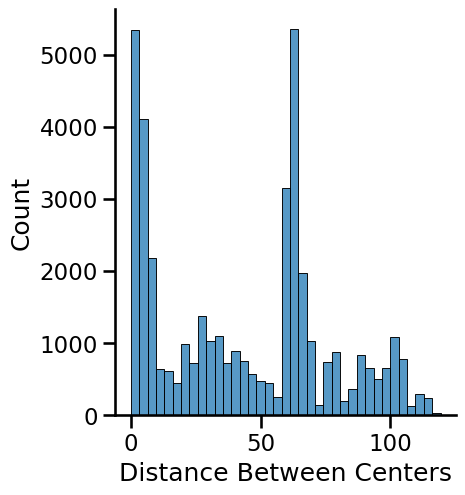

In [11]:
ax = sns.displot(np.reshape(dist_mat,-1))
ax.axes[0,0].set_xlabel("Distance Between Centers")

Plot the distribution of volume ratios

Text(0.5, 21.44444444444443, 'Volume Ratio')

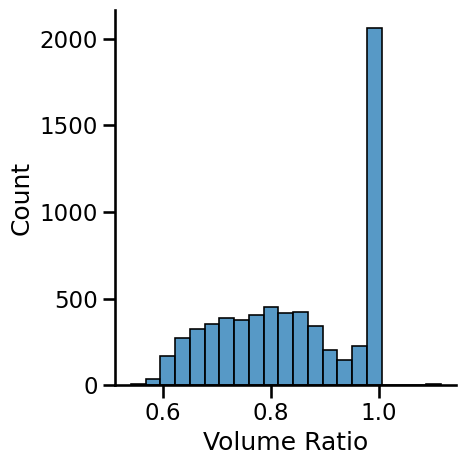

In [12]:
g = sns.displot(vol_df.vol_ratio)
g.axes[0,0].set_xlabel("Volume Ratio")


Bin the volume ratio into 5 bins

In [13]:
vol_df['bin'] = pd.qcut(vol_df.vol_ratio,q=5,labels=[1,2,3,4,5])

Examine structure pairs in different bins.  Change bin_val to see structures. 

In [17]:
vol_df.query("bin == @bin_val",engine='python')

,ROMol,i,j,name_i,name_j,dist,vol_i,vol_j,combo_vol,vol_ratio,bin
2,<rdkit.Chem.rdchem.Mol object at 0x3054a7ca0>,1,2,5RVJ,5RVK,15.347336,129.408,151.144,280.536,0.999943,5
3,<rdkit.Chem.rdchem.Mol object at 0x3054a7290>,1,4,5RVJ,5RVM,19.274792,129.408,110.336,239.680,0.999733,5
4,<rdkit.Chem.rdchem.Mol object at 0x3054a71b0>,1,5,5RVJ,5RVN,18.818836,129.408,121.560,251.016,1.000191,5
5,<rdkit.Chem.rdchem.Mol object at 0x3054a6f10>,1,8,5RVJ,5RVQ,19.459123,129.408,138.768,268.384,1.000776,5
6,<rdkit.Chem.rdchem.Mol object at 0x3054a7140>,1,10,5RVJ,5RVS,18.511077,129.408,160.840,290.216,0.999890,5
...,...,...,...,...,...,...,...,...,...,...,...
6604,<rdkit.Chem.rdchem.Mol object at 0x305ea1d90>,196,202,5S44,5S4J,7.438507,119.704,107.912,227.528,0.999613,5
6609,<rdkit.Chem.rdchem.Mol object at 0x305ea1af0>,197,202,5S45,5S4J,8.028806,139.520,107.912,247.560,1.000517,5
6611,<rdkit.Chem.rdchem.Mol object at 0x305ea2030>,198,200,5S46,5S4H,5.214817,73.304,132.120,205.592,1.000818,5
6612,<rdkit.Chem.rdchem.Mol object at 0x305ea18c0>,198,201,5S46,5S4I,6.593000,73.304,167.040,240.248,0.999601,5


In [22]:
bin_val = 5
s = vol_df.query("bin == @bin_val",engine='python').sample(1)
i,j = s.i.values[0],s.j.values[0]
mol_i = df.ROMol.values[i]
mol_j = df.ROMol.values[j]
mol_ij = Chem.CombineMols(mol_i,mol_j)
MolTo3DView(mol_ij)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
PandasTools.WriteSDF(vol_df.query("bin >= 4",engine='python'),"pairs_4_5.sdf",properties=vol_df.columns[1:])